In [1]:
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
from itertools import islice
import numpy as np

from skimage.external import tifffile
from skimage.external.tifffile import imread

import matplotlib.pyplot as plt

import ipywidgets as widgets

import random


from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor

from scipy import ndimage
from PIL import Image, ImageDraw

import numpy.ma as ma

from skimage.measure import label, regionprops

## to calculate

1_20layer_volume/HP1B/MCM/DAPI_total/hetChrom/euChrom

20 * 4 * 3 = 240 signals

# gathering files
deleting the columns with the signals to recalculate and collect data

In [2]:
numLayers = 20

In [3]:
bigDir=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [4]:
newfile=f'{bigDir}\\new dataset\signals_new_v4.csv'

In [5]:
newdata=pd.read_csv(newfile)

In [6]:
newdata=newdata.drop(columns=['Unnamed: 0'])

In [7]:
newdata.head()

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,nuc_DAPI_het,inner_DAPI_het,outer_DAPI_het,nuc_DAPI_eu,inner_DAPI_eu,outer_DAPI_eu,day,decon,p_age,mol_age_mod
0,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,3,...,1.812075e+09,1.086345e+09,725729186.0,4.615195e+09,1.007696e+09,3.607499e+09,d20191203,False,NaN,1.373
1,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,1.229128e+09,5.907975e+08,638330656.0,2.382242e+09,2.544991e+08,2.127743e+09,d20191203,False,1.500000,0.226
2,20191203_cell-05.czi,20191125-01-36,191125pcnat_dhbr_cdc6vxy01,1705.099,468.246,MCM3,1,HP1beta,2,3,...,1.336272e+09,8.335653e+08,502707049.0,2.233975e+09,2.555882e+08,1.978387e+09,d20191203,False,2.166667,0.632
3,20191203_cell-08.czi,20191125-01-41,191125pcnat_dhbr_cdc6vxy01,332.674,553.990,MCM3,1,HP1beta,2,3,...,9.643314e+08,5.258328e+08,438498603.0,2.153495e+09,3.529459e+08,1.800549e+09,d20191203,False,5.833333,0.759
4,20191203_cell-11.czi,20191125-01-54,191125pcnat_dhbr_cdc6vxy01,647.356,843.150,MCM3,1,HP1beta,2,3,...,9.153324e+08,3.707237e+08,544608651.0,2.008052e+09,3.305668e+08,1.677485e+09,d20191203,False,6.666667,0.325


In [8]:
len(newdata)

150

## Calculations

In [9]:
%%time

i=0
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(newdata),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,myCell in newdata.iterrows():
    
    # open cell image
    myCell.path = myCell.path.replace('Z:','S:')
    try:
        temp=imread(myCell.path) 
    except:
        myCell.path=myCell.path.replace('.tif','.tiff')
        temp=imread(myCell.path)
    
    myImage = np.zeros([temp.shape[0],4,temp.shape[2],temp.shape[3]]).astype(float)
    myImage[:,:3,:,:] = temp
    myImage[:,3,:,:] = 1.0
    
    # open corresponding onion image
    onionFolder = os.path.dirname(myCell.path).replace('data_tiff',f'onion{numLayers}_nuc_mask')
    maskFile = os.path.basename(myCell.path).replace('.tif',f'_onion{numLayers}.tif')
    maskFile = maskFile.replace('.tiff','.tif')
    myOnion = imread(os.path.join(onionFolder,maskFile))
    
    # open corresponding hetChrom mask
    hetFolder = os.path.dirname(myCell.path).replace('data_tiff','segmentation_20')
    maskFile = os.path.basename(myCell.path).replace('.tif','_hetChrom.tif')
    het = imread(os.path.join(hetFolder,maskFile))
    het = het.astype(bool)
    
    # open corresponding euChrom mask
    euFolder = os.path.dirname(myCell.path).replace('data_tiff','segmentation_20_eu')
    maskFile = os.path.basename(myCell.path).replace('.tif','_euChrom.tif')
    eu = imread(os.path.join(euFolder,maskFile))
    eu = eu.astype(bool)
    
    # create total mask
    total = myOnion>0
    
    # define chromatin regions
    pixels=['total','het','eu']
    names = ['vol','DAPI','MCM','HP1B']
    channels = [3,2,0,1]
        
    for chrom in pixels:

        for ch,name in zip(channels,names):

            # full nucleus signal
            myName = f'nuc_{name}_{chrom}'            
            temp = myImage[:,ch,:,:]*eval(chrom)
            signal = np.sum(temp)
            newdata.loc[i,myName] = signal  
                        
            # calculate for each layer
            for j in np.arange(1,numLayers+1):
        
                myLayer = (myOnion==j)

                # layer signal
                myName = f'{str(j).zfill(2)}_{name}_{chrom}'
                signal = np.sum(temp[myLayer])
                newdata.loc[i,myName] = signal                       
    
    progBar.value=progBar.value+1

IntProgress(value=0, description='Progress:', max=150)

Wall time: 9min 39s


In [10]:
len(list(newdata.columns))

296

In [11]:
list(newdata.columns)

['file',
 'original cell name',
 'movie',
 'last frame movie position x',
 'last frame movie position y',
 'ab1 (MCM)',
 'ab1 ch',
 'ab2 (heterochromatin)',
 'ab2 ch',
 'DAPI ch',
 'DIC ch',
 'category',
 'molecular age ',
 'physical age [min]',
 'imaging core',
 'cell id for tracking',
 'comment',
 'molecular age 10',
 'path',
 'nuc_vol_total',
 'inner_vol_total',
 'outer_vol_total',
 'nuc_mcm_total',
 'inner_mcm_total',
 'outer_mcm_total',
 'nuc_vol_het',
 'inner_vol_het',
 'outer_vol_het',
 'nuc_mcm_het',
 'inner_mcm_het',
 'outer_mcm_het',
 'nuc_vol_eu',
 'inner_vol_eu',
 'outer_vol_eu',
 'nuc_mcm_eu',
 'inner_mcm_eu',
 'outer_mcm_eu',
 'nuc_DAPI_total',
 'inner_DAPI_total',
 'outer_DAPI_total',
 'nuc_DAPI_het',
 'inner_DAPI_het',
 'outer_DAPI_het',
 'nuc_DAPI_eu',
 'inner_DAPI_eu',
 'outer_DAPI_eu',
 'day',
 'decon',
 'p_age',
 'mol_age_mod',
 '01_vol_total',
 '02_vol_total',
 '03_vol_total',
 '04_vol_total',
 '05_vol_total',
 '06_vol_total',
 '07_vol_total',
 '08_vol_total',
 '09

In [12]:
# test functions
# for newly calculated signals
pixels=['total','het','eu']

signals = ['vol','HP1B','DAPI','MCM']

for chrom in pixels:
       
    for signal in signals:
        
        temp = np.zeros(len(newdata))
        
        for j in np.arange(1,numLayers+1):
    
            myName = f'{str(j).zfill(2)}_{signal}_{chrom}'
    
            myColumn = newdata[myName]
        
            temp = temp + myColumn
            
        test = ((np.sum(temp - newdata[f'nuc_{signal}_{chrom}'])))
            
        print(f'{signal}_{chrom}: {test}')

vol_total: 0.0
HP1B_total: 0.0
DAPI_total: 0.0
MCM_total: 0.0
vol_het: 0.0
HP1B_het: 0.0
DAPI_het: 0.0
MCM_het: 0.0
vol_eu: 0.0
HP1B_eu: 0.0
DAPI_eu: 0.0
MCM_eu: 0.0


<IPython.core.display.Javascript object>


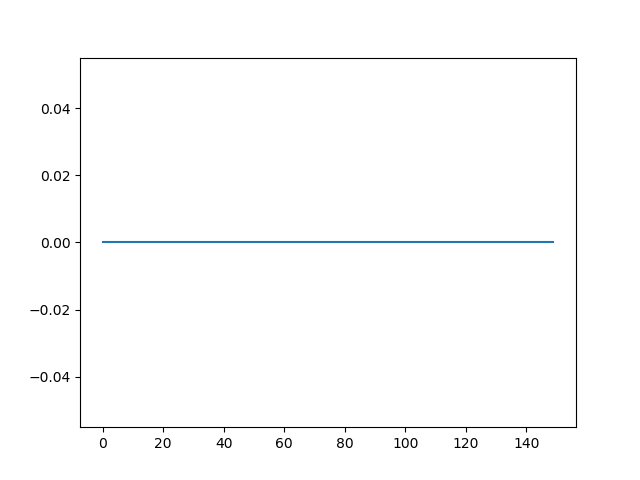

In [13]:
%matplotlib notebook
plt.plot(newdata['nuc_vol_het']+newdata['nuc_vol_eu']-newdata['nuc_vol_total'])

<IPython.core.display.Javascript object>


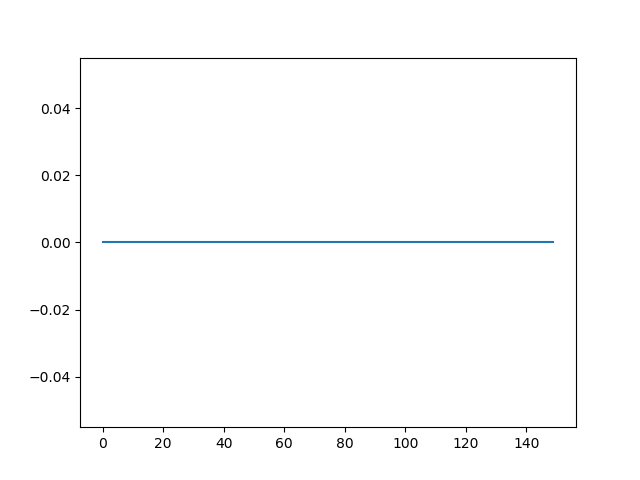

In [14]:
%matplotlib notebook
plt.plot((temp - newdata[f'nuc_{signal}_{chrom}'])>0)

In [ ]:
# divide into n layers by volume

n = 2

myVolume = 0

ind = 0

for i,myCell in newdata.iterrows():

    for j in np.arange(1,numLayers+1):

        myVolume = myVolume + myCell[f'{str(j).zfill(2)}_vol_total']
        myVolumeRatio = myVolume/myCell['nuc_vol_total']
        
        if myVolumeRatio > 0.5:
            
            print(j)
            
            break
            
    


In [ ]:
for i,myCell in newdata.iterrows():

In [15]:
## saving the dataset to csv file
newdata.to_csv(newfile.replace('v4','v5_kmk'))

the data/signal calculations that were done in this file will be retreived in the other file - '200221_DAPI_calculations'